In [54]:
#import useful libraries

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import networkx as nx
import random


In [55]:
# time init
start = time.time()

In [56]:
# Étape 1 : Chargement et nettoyage des données
def load_and_clean_data(filepath):
    # csv file to dataframe
    file_path = "orders.csv"  # Remplace par le chemin réel de ton fichier
    columns = ["OrderHash", "Block", "Action", "Price", "Quantity", "OrderType", "SubaccountID"]
    df = pd.read_csv(file_path, names=columns, skiprows=1)

    return df


df = load_and_clean_data(filepath="orders.csv")
data=df.copy()
subaccounts = df["SubaccountID"].unique()

#match subaccount to a number

subaccount_num_mapping = {idx :subaccount for idx, subaccount in enumerate(subaccounts)}
subaccount_num_mapping

{0: '0x5303d92e49a619bb29de8fb6f59c0e7589213cc8000000000000000000000001',
 1: '0x21596b451da15002ebbb91661f7f5e9f2f372343000000000000000000000011',
 2: '0xed8c4c43e03e24b7f12975472da771ce2f8b857c000000000000000000000000',
 3: '0xbcc871dab5a507624e55afeaa93610a424c446cc000000000000000000000000',
 4: '0x5303d92e49a619bb29de8fb6f59c0e7589213cc8000000000000000000000004',
 5: '0x45413d9cb161b88099123c31c720e57f276b8f2b000000000000000000000003',
 6: '0x5303d92e49a619bb29de8fb6f59c0e7589213cc8000000000000000000000002',
 7: '0x45413d9cb161b88099123c31c720e57f276b8f2b000000000000000000000002',
 8: '0x7cf40a60c390723ec2d34c2fef23314d830eed22000000000000000000000000',
 9: '0x31307ef22c77cc89cd7e61246608f15b82d09fed000000000000000000000001',
 10: '0xe5b451c363197d375904ec167d8ed10b7bbd1e63000000000000000000000002',
 11: '0xe254824846257f132fdcac1115c4ca9fead4f47c000000000000000000000000'}

In [57]:
#IDENTIFY MARKETMAKERS




# Initialiser les listes pour les ratios d'annulation, les scores de symétrie et le marketmaker_score
ratios = []
symmetry_scores = []
marketmaker_scores = []
action_counts = []  # Liste pour stocker le nombre d'actions de chaque subaccount

# Boucle pour chaque subaccount
for i in subaccount_num_mapping.keys():
    subaccount = subaccount_num_mapping[i]
    # Filtrer les ordres du subaccount
    subaccount_orders = data[data["SubaccountID"] == subaccount]
    
    # Calcul du ratio d'annulations
    total_orders = len(subaccount_orders)
    cancel_orders = len(subaccount_orders[subaccount_orders["Action"] == "EVENT_CANCEL"])
    ratio = cancel_orders / total_orders if total_orders > 0 else 0
    ratios.append(ratio)
    
    # Calcul du score de symétrie
    buy_orders = len(subaccount_orders[subaccount_orders["OrderType"].isin(["BUY", "BUY_PO"])])
    sell_orders = len(subaccount_orders[subaccount_orders["OrderType"].isin(["SELL", "SELL_PO"])])
    symmetry_score = ( buy_orders - sell_orders )
    symmetry_scores.append(symmetry_score)
    
    # Calcul du nombre total d'actions (ordres) du subaccount
    action_counts.append(total_orders)

# Étape 2 : Normaliser les scores de symétrie entre 0 et 1
symmetry_scores_normalized = (symmetry_scores - np.min(symmetry_scores)) / (np.max(symmetry_scores) - np.min(symmetry_scores))

# Étape 3 : Calculer le marketmaker_score pour chaque subaccount en tenant compte du nombre d'actions
for i in subaccount_num_mapping.keys():  
    ratio = ratios[i]
    symmetry_norm = symmetry_scores_normalized[i]
    action_count = action_counts[i]
    action_weight = action_count / max(action_counts)  # Normalisation par rapport au max du nombre d'actions
    marketmaker_score = (2*ratio + 2*symmetry_norm + action_weight) / 5  # Moyenne des scores
    marketmaker_scores.append((i,marketmaker_score))

# Afficher les résultats
for i in subaccount_num_mapping.keys():
    subaccount=subaccount_num_mapping[i]
    print(f"Subaccount {i} ({subaccount}):")
    print(f"  Ratio d'annulation = {ratios[i]:.2f}")
    print(f"  Symmetry Score Normalisé = {symmetry_scores_normalized[i]:.2f}")
    print(f"  Marketmaker Score = {marketmaker_scores[i][1]:.2f}")
    
top_marketmakers = sorted(marketmaker_scores, key=lambda x: x[1],reverse=True)

#We choose to consider only 2 marketmakers

index_first=top_marketmakers[0][0]
index_second=top_marketmakers[1][0]
print(f"Marketmaker #1: Subaccount {index_first} ({subaccount_num_mapping[index_first]}) with Marketmaker Score = {top_marketmakers[0][1]:.2f}")
print(f"Marketmaker #2: Subaccount {index_second} ({subaccount_num_mapping[index_second]}) with Marketmaker Score = {top_marketmakers[1][1]:.2f}")



Subaccount 0 (0x5303d92e49a619bb29de8fb6f59c0e7589213cc8000000000000000000000001):
  Ratio d'annulation = 0.50
  Symmetry Score Normalisé = 0.00
  Marketmaker Score = 0.31
Subaccount 1 (0x21596b451da15002ebbb91661f7f5e9f2f372343000000000000000000000011):
  Ratio d'annulation = 0.50
  Symmetry Score Normalisé = 1.00
  Marketmaker Score = 0.77
Subaccount 2 (0xed8c4c43e03e24b7f12975472da771ce2f8b857c000000000000000000000000):
  Ratio d'annulation = 0.64
  Symmetry Score Normalisé = 0.46
  Marketmaker Score = 0.64
Subaccount 3 (0xbcc871dab5a507624e55afeaa93610a424c446cc000000000000000000000000):
  Ratio d'annulation = 1.00
  Symmetry Score Normalisé = 0.07
  Marketmaker Score = 0.44
Subaccount 4 (0x5303d92e49a619bb29de8fb6f59c0e7589213cc8000000000000000000000004):
  Ratio d'annulation = 0.50
  Symmetry Score Normalisé = 0.49
  Marketmaker Score = 0.53
Subaccount 5 (0x45413d9cb161b88099123c31c720e57f276b8f2b000000000000000000000003):
  Ratio d'annulation = 0.50
  Symmetry Score Normalisé = 

In [58]:
#IDENTIFY DEGEN LEVERAGE SEEKERS

# Étape 1 : Extraire les 12 premiers subaccounts (numérotés de 0 à 11)
subaccounts = data["SubaccountID"].unique()[:12]

# Initialiser les listes pour les métriques
leverage_usages = []
buy_sell_skews = []
leverage_seeker_scores = []

# Boucle pour chaque subaccount
for i in subaccount_num_mapping.keys():
    # Filtrer les ordres du subaccount
    subaccount_orders = data[data["SubaccountID"] == subaccount]
    subaccount= subaccount_num_mapping[i]
    
    # Calcul de l'utilisation de la "marge" comme proxy basé sur la taille de l'ordre
    total_order_values = subaccount_orders["Quantity"] * subaccount_orders["Price"]
    avg_order_value = total_order_values.mean() if not total_order_values.empty else 0
    leverage_usage = avg_order_value / total_order_values.sum() if total_order_values.sum() > 0 else 0
    leverage_usages.append(leverage_usage)
    
    # Calcul du déséquilibre achat/vente
    buy_orders = len(subaccount_orders[subaccount_orders["OrderType"].isin(["BUY", "BUY_PO"])])
    sell_orders = len(subaccount_orders[subaccount_orders["OrderType"].isin(["SELL", "SELL_PO"])])
    buy_sell_skew = 1- abs(buy_orders - sell_orders) / (buy_orders + sell_orders) if (buy_orders + sell_orders) > 0 else 0
    buy_sell_skews.append(buy_sell_skew)

# Étape 2 : Normaliser les métriques entre 0 et 1
leverage_usages_normalized = (leverage_usages - np.min(leverage_usages)) / (np.max(leverage_usages) - np.min(leverage_usages))
buy_sell_skews_normalized = (buy_sell_skews - np.min(buy_sell_skews)) / (np.max(buy_sell_skews) - np.min(buy_sell_skews))

# Étape 3 : Calculer le score "degen leverage seeker" pour chaque subaccount
for i in subaccount_num_mapping.keys():
    leverage_norm = leverage_usages_normalized[i]
    skew_norm = buy_sell_skews_normalized[i]
    leverage_seeker_score = (leverage_norm + skew_norm) / 2  # Moyenne des deux scores normalisés
    leverage_seeker_scores.append((i,leverage_seeker_score))

# Afficher les résultats
for i in subaccount_num_mapping.keys():
    subaccount=subaccount_num_mapping[i]
    print(f"Subaccount {i} ({subaccount}):")
    print(f"  Leverage Usage Normalisé = {leverage_usages_normalized[i]:.2f}")
    print(f"  Buy/Sell Skew Normalisé = {buy_sell_skews_normalized[i]:.2f}")
    print(f"  Leverage Seeker Score = {leverage_seeker_scores[i][1]:.2f}")

top_leverage_seekers = sorted(enumerate(leverage_seeker_scores), key=lambda x: x[1], reverse=True)




Subaccount 0 (0x5303d92e49a619bb29de8fb6f59c0e7589213cc8000000000000000000000001):
  Leverage Usage Normalisé = 1.00
  Buy/Sell Skew Normalisé = 0.86
  Leverage Seeker Score = 0.93
Subaccount 1 (0x21596b451da15002ebbb91661f7f5e9f2f372343000000000000000000000011):
  Leverage Usage Normalisé = 0.00
  Buy/Sell Skew Normalisé = 0.97
  Leverage Seeker Score = 0.49
Subaccount 2 (0xed8c4c43e03e24b7f12975472da771ce2f8b857c000000000000000000000000):
  Leverage Usage Normalisé = 0.00
  Buy/Sell Skew Normalisé = 0.94
  Leverage Seeker Score = 0.47
Subaccount 3 (0xbcc871dab5a507624e55afeaa93610a424c446cc000000000000000000000000):
  Leverage Usage Normalisé = 0.00
  Buy/Sell Skew Normalisé = 0.98
  Leverage Seeker Score = 0.49
Subaccount 4 (0x5303d92e49a619bb29de8fb6f59c0e7589213cc8000000000000000000000004):
  Leverage Usage Normalisé = 0.02
  Buy/Sell Skew Normalisé = 0.81
  Leverage Seeker Score = 0.42
Subaccount 5 (0x45413d9cb161b88099123c31c720e57f276b8f2b000000000000000000000003):
  Leverage U

In [59]:
    #IDENTIFY SCALPERS

    # Initialiser les listes pour les ratios, les scores et le scalper_score
    holding_times = []
    order_frequencies = []
    scalper_scores = []

    # Boucle pour chaque subaccount
    for i in subaccount_num_mapping.keys():
        subaccount=subaccount_num_mapping[i]
        # Filtrer les ordres du subaccount
        subaccount_orders = data[data["SubaccountID"] == subaccount]
        
        # Filtrer les ordres d'achat et de vente
        buy_orders = subaccount_orders[subaccount_orders["OrderType"].isin(["BUY", "BUY_PO"])]
        sell_orders = subaccount_orders[subaccount_orders["OrderType"].isin(["SELL", "SELL_PO"])]
        
        # Calculer le temps moyen de détention (différence entre le bloc d'achat et le bloc de vente)
        if not buy_orders.empty and not sell_orders.empty:
            avg_holding_time = np.mean([
                sell_block - buy_block
                for buy_block in buy_orders["Block"]
                for sell_block in sell_orders["Block"]
                if sell_block >= buy_block
            ])
        else:
            avg_holding_time = float('inf')  # Aucun ordre d'achat/vente pairé
        
        holding_times.append(avg_holding_time)
        
        # Calculer la fréquence des ordres par bloc
        orders_per_block = subaccount_orders.groupby("Block").size()
        avg_orders_per_block = orders_per_block.mean()  # Moyenne des ordres par bloc
        order_frequencies.append(avg_orders_per_block)
        
    # Étape 2 : Normaliser les scores entre 0 et 1
    holding_times_normalized = (1 - (holding_times - np.min(holding_times)) / (np.max(holding_times) - np.min(holding_times)))
    order_frequencies_normalized = (order_frequencies - np.min(order_frequencies)) / (np.max(order_frequencies) - np.min(order_frequencies))

    # Étape 3 : Calculer le scalper_score pour chaque subaccount
    for i in subaccount_num_mapping.keys():
        holding_time_norm = holding_times_normalized[i]
        order_freq_norm = order_frequencies_normalized[i]
        scalper_score = (holding_time_norm + order_freq_norm) / 2  # Moyenne des deux scores normalisés
        scalper_scores.append((i,scalper_score))

    # Afficher les résultats
    for i in subaccount_num_mapping.keys():
        subaccount=subaccount_num_mapping[i]
        print(f"Subaccount {i} ({subaccount}):")
        print(f"  Average Holding Time = {holding_times[i]:.2f} blocks")
        print(f"  Average Orders per Block = {order_frequencies[i]:.2f}")
        print(f"  Scalper Score = {scalper_scores[i][1]:.2f}")

    # Trouver les top scalpers
    top_scalpers = sorted(enumerate(scalper_scores), key=lambda x: x[1], reverse=True)[:5]


Subaccount 0 (0x5303d92e49a619bb29de8fb6f59c0e7589213cc8000000000000000000000001):
  Average Holding Time = 746.83 blocks
  Average Orders per Block = 2.02
  Scalper Score = 0.57
Subaccount 1 (0x21596b451da15002ebbb91661f7f5e9f2f372343000000000000000000000011):
  Average Holding Time = 758.84 blocks
  Average Orders per Block = 2.46
  Scalper Score = 0.61
Subaccount 2 (0xed8c4c43e03e24b7f12975472da771ce2f8b857c000000000000000000000000):
  Average Holding Time = 733.31 blocks
  Average Orders per Block = 4.32
  Scalper Score = 0.77
Subaccount 3 (0xbcc871dab5a507624e55afeaa93610a424c446cc000000000000000000000000):
  Average Holding Time = 785.02 blocks
  Average Orders per Block = 1.17
  Scalper Score = 0.50
Subaccount 4 (0x5303d92e49a619bb29de8fb6f59c0e7589213cc8000000000000000000000004):
  Average Holding Time = 770.18 blocks
  Average Orders per Block = 2.98
  Scalper Score = 0.66
Subaccount 5 (0x45413d9cb161b88099123c31c720e57f276b8f2b000000000000000000000003):
  Average Holding Time

C:\Users\Adam\AppData\Local\Temp\ipykernel_3000\634623191.py:37: RuntimeWarning: invalid value encountered in divide
  holding_times_normalized = (1 - (holding_times - np.min(holding_times)) / (np.max(holding_times) - np.min(holding_times)))


In [60]:

# Charger les données du fichier CSV
# Remplacez 'orders.csv' par le chemin de votre fichier CSV
orders_data = pd.read_csv("orders.csv")

# Initialisation des listes pour les métriques
average_order_sizes = []
total_order_counts = []
swing_trader_scores = []

# Identifier les subaccounts uniques
subaccounts = orders_data["SubaccountID"].unique()

# Boucle pour chaque subaccount
for subaccount in subaccounts:
    # Filtrer les ordres du subaccount
    subaccount_orders = orders_data[orders_data["SubaccountID"] == subaccount]

    # Calcul de la taille moyenne des ordres
    total_order_sizes = subaccount_orders["Quantity"] * subaccount_orders["Price"]
    average_order_size = total_order_sizes.mean() if not total_order_sizes.empty else 0
    average_order_sizes.append(average_order_size)

    # Calcul du nombre total d'ordres
    total_orders = len(subaccount_orders)
    total_order_counts.append(total_orders)

# Étape 1 : Normaliser les tailles moyennes et les nombres d'ordres entre 0 et 1
average_order_sizes_normalized = (average_order_sizes - np.min(average_order_sizes)) / (np.max(average_order_sizes) - np.min(average_order_sizes))
total_order_counts_normalized = (total_order_counts - np.min(total_order_counts)) / (np.max(total_order_counts) - np.min(total_order_counts))

# Étape 2 : Calculer le score de swing trader pour chaque subaccount
for i, subaccount in enumerate(subaccounts):
    # Critères : faible nombre d'ordres et grande taille moyenne des ordres
    order_size_norm = average_order_sizes_normalized[i]
    order_count_norm = 1 - total_order_counts_normalized[i]  # Inverser pour privilégier un faible nombre d'ordres
    swing_trader_score = (2 * order_size_norm + order_count_norm) / 3  # Moyenne pondérée
    swing_trader_scores.append((i, swing_trader_score))

# Afficher les résultats
for i, subaccount in enumerate(subaccounts):
    print(f"Subaccount {i} ({subaccount}):")
    print(f"  Taille moyenne des ordres normalisée = {average_order_sizes_normalized[i]:.2f}")
    print(f"  Nombre d'ordres (inverse normalisé) = {1 - total_order_counts_normalized[i]:.2f}")
    print(f"  Swing Trader Score = {swing_trader_scores[i][1]:.2f}")

# Identifier les meilleurs swing traders
top_swing_traders = sorted(swing_trader_scores, key=lambda x: x[1], reverse=True)

# Afficher les 2 swing traders les plus probables
index_first = top_swing_traders[0][0]
index_second = top_swing_traders[1][0]
print(f"\nSwing Trader #1: Subaccount {index_first} ({subaccounts[index_first]}) avec un score de {top_swing_traders[0][1]:.2f}")
print(f"Swing Trader #2: Subaccount {index_second} ({subaccounts[index_second]}) avec un score de {top_swing_traders[1][1]:.2f}")


Subaccount 0 (0x5303d92e49a619bb29de8fb6f59c0e7589213cc8000000000000000000000001):
  Taille moyenne des ordres normalisée = 0.02
  Nombre d'ordres (inverse normalisé) = 0.46
  Swing Trader Score = 0.16
Subaccount 1 (0x21596b451da15002ebbb91661f7f5e9f2f372343000000000000000000000011):
  Taille moyenne des ordres normalisée = 0.03
  Nombre d'ordres (inverse normalisé) = 0.13
  Swing Trader Score = 0.06
Subaccount 2 (0xed8c4c43e03e24b7f12975472da771ce2f8b857c000000000000000000000000):
  Taille moyenne des ordres normalisée = 0.13
  Nombre d'ordres (inverse normalisé) = 0.00
  Swing Trader Score = 0.09
Subaccount 3 (0xbcc871dab5a507624e55afeaa93610a424c446cc000000000000000000000000):
  Taille moyenne des ordres normalisée = 0.07
  Nombre d'ordres (inverse normalisé) = 0.95
  Swing Trader Score = 0.36
Subaccount 4 (0x5303d92e49a619bb29de8fb6f59c0e7589213cc8000000000000000000000004):
  Taille moyenne des ordres normalisée = 0.44
  Nombre d'ordres (inverse normalisé) = 0.32
  Swing Trader Sco

In [61]:


# Initialisation du temps
start = time.time()

# Étape 1 : Chargement et nettoyage des données
def load_and_clean_data(filepath):
    # Lecture du fichier CSV
    file_path = "orders.csv"  # Remplace par le chemin réel de ton fichier
    columns = ["OrderHash", "Block", "Action", "Price", "Quantity", "OrderType", "SubaccountID"]
    df = pd.read_csv(file_path, names=columns, skiprows=1)

    return df


# Étape 2 : Identifier des liens d'influence
def detect_influence_links(df, time_window=60):
    # Liste pour stocker les liens d'influence
    influence_links = []

    # Trier les données par bloc et sous-compte
    df = df.sort_values(by=['Block', 'SubaccountID'])

    # On nomme les comptes avec leur numéro d'apparition
    accounts = {}
    numero = 0

    # Permet de connaître qui a agit sur le bloc courant
    actions_on_block = [0 for _ in range(df["SubaccountID"].nunique())]
    block_number = 0

    # Calculer les différences de blocs entre les actions
    for _, row in df.iterrows():

        # Si changement de block, on enregistre les acteurs du block dans la matrice
        if row['Block'] != block_number :
            block_number = row['Block']
            influence_links.append(actions_on_block)
            actions_on_block = [0 for _ in range(df["SubaccountID"].nunique())]

        # On nomme les comptes pas visités
        if row['SubaccountID'] not in accounts :
            accounts[row['SubaccountID']] = numero
            numero += 1
        
        # On enregistre l'acteur sur le block courant
        actions_on_block[accounts[row['SubaccountID']]] = 1

    # Retourner les liens d'influence détectés
    return np.array(influence_links)


def graphe(actions_simultanees) :

    # Étape 3.1 : Construction du réseau d'interactions
    # Graphique des influences
    G = nx.DiGraph()

    # Ajouter des nœuds pour chaque SubaccountID unique
    subaccounts = []
    for k in range(len(actions_simultanees)) :
        subaccounts.append(k)
    G.add_nodes_from(subaccounts)

    # On ajoute les arêtes d'influences avec leur poids entre les comptes
    for i in range(len(actions_simultanees)) :
        for j in range(len(actions_simultanees[0])) :
            if actions_simultanees[i][j] != 0 :
                G.add_edge(i, j, weight=actions_simultanees[i][j])

    return G


# Exemple d'exécution
if __name__ == "__main__":
    filepath = "orders.csv"  # Remplacez par le chemin de votre fichier

    # Étape 1 : Chargement et nettoyage des données
    df_clean = load_and_clean_data(filepath)
    
    # Étape 2 : Détection des liens d'influence
    influence_links = detect_influence_links(df_clean)


    actions_simultanees = influence_links.T @ influence_links


    graphe(actions_simultanees)


In [62]:
##CLASSE DES TRADERS


# --- Définition des classes de traders ---
class Trader:
    """Classe de base pour tous les traders."""
    def __init__(self, trader_id, balance, market_price, leverage):
        self.trader_id = trader_id
        self.balance = balance
        self.leverage = leverage
        self.position = 'SELL'  # 'BUY', 'SELL', 'NEUTRAL' ou 'LIQUIDATED'
        self.entry_price = market_price
        self.margin = balance / leverage
        self.liquidation_price = self.calculate_liquidation_price()
        self.is_liquidated = False
        self.herding_prob = 0

    def open_position(self, position, price):
        """Ouvre une position en fonction du prix du marché."""
        self.position = position
        self.entry_price = price
        self.liquidation_price = self.calculate_liquidation_price()

    def calculate_liquidation_price(self):
        """Calcule le prix auquel ce trader sera liquidé."""
        if self.position == 'BUY':
            return self.entry_price * (1 - (self.margin / (self.balance * self.leverage)))
        elif self.position == 'SELL':
            return self.entry_price * (1 + (self.margin / (self.balance * self.leverage)))
        return 'NEUTRAL'

    def check_liquidation(self, market_price):
        """Vérifie si le trader doit être liquidé."""
        if self.position and not self.is_liquidated:
            if (self.position == 'BUY' and market_price <= self.liquidation_price) or \
               (self.position == 'SELL' and market_price >= self.liquidation_price):
                self.is_liquidated = True
                self.position = 'LIQUIDATED'
                self.entry_price = 0
                self.liquidation_price = 1
                print(f"Trader {self.trader_id} liquidated at price {market_price}")
                return True
            
    def follows_herd(self, market_price, herd_position) :
            if random.random() < self.herding_prob :
                self.open_position(herd_position, market_price)
                return True

class MarketMaker(Trader):
    """Trader Market Maker - Fournit de la liquidité."""
    def __init__(self, trader_id, balance, market_price):
        super().__init__(trader_id, balance, market_price, leverage=random.choice([2, 5]))
        self.herding_prob = 0.1  # Faible mimétisme

    def place_limit_orders(self):
        """Place des ordres limites pour fournir de la liquidité."""
        print(f"Market Maker {self.trader_id} place un ordre limite.")

    def what_does_he_do(self, market_price, trend, herd_position) :
        if not self.is_liquidated:
            quantity = round(random.uniform(0.01, 2.0), 3)
            order_types = ['BUY_PO', 'SELL_PO', 'BUY', 'SELL']
            order_type = random.choice(order_types)
            if self.follows_herd(herd_position, market_price) :
                return herd_position, quantity
            if self.check_liquidation(market_price) :
                return "LIQUIDATED", quantity
            self.open_position(order_type, market_price)
            return order_type, quantity

class DegenTrader(Trader):
    """Trader Degen - Très spéculatif et risqué."""
    def __init__(self, trader_id, balance, market_price):
        super().__init__(trader_id, balance, market_price, leverage=random.choice([10, 20, 50]))
        print(self.margin)
        self.herding_prob = 0.8  # Très influencé par les autres

    def panic_sell(self, market_price):
        """Vend rapidement en cas de forte baisse."""
        if self.position == 'BUY' and random.random() < self.herding_prob:
            print(f"Degen Trader {self.trader_id} panique et vend au marché !")
            self.open_position('SELL', market_price)
            return True

    def what_does_he_do(self, market_price, trend, herd_position) :
        if not self.is_liquidated:
            quantity = round(random.uniform(0.01, 2.0), 3)
            order_types = ['BUY_PO', 'SELL_PO', 'BUY', 'SELL']
            order_type = random.choice(order_types)
            if self.follows_herd(herd_position, market_price) :
                return herd_position, quantity
            if self.check_liquidation(market_price) :
                return "LIQUIDATED", quantity
            if self.panic_sell(market_price) :
                return self.position, quantity
            self.open_position(order_type, market_price)
            return order_type, quantity
        


class SwingTrader(Trader):
    """Trader Swing - Suit les tendances macro."""
    def __init__(self, trader_id, balance, market_price):
        super().__init__(trader_id, balance, market_price, leverage=random.choice([5, 10, 20]))
        self.herding_prob = 0.5  # Moyenne sensibilité au marché

    def follows_trend(self, trend_signal, market_price):
        """Suit la tendance du marché (BUY si haussier, SELL si baissier)."""
        if trend_signal == 'bullish':
            self.open_position('BUY', market_price)
            return True
        elif trend_signal == 'bearish':
            self.open_position('SELL', market_price)
            return True

    def what_does_he_do(self, market_price, trend, herd_position) :
        if not self.is_liquidated:
            quantity = round(random.uniform(0.01, 2.0), 3)
            order_types = ['BUY_PO', 'SELL_PO', 'BUY', 'SELL']
            order_type = random.choice(order_types)
            if self.follows_herd(herd_position, market_price) :
                return herd_position, quantity
            if self.check_liquidation(market_price) :
                return "LIQUIDATED", quantity
            if self.follows_trend(trend, market_price) :
                return self.position, quantity
            self.open_position(order_type, market_price)
            return order_type, quantity

class ArbitrageTrader(Trader):
    """Trader Arbitrage - Exploite les écarts de prix."""
    def __init__(self, trader_id, balance, market_price):
        super().__init__(trader_id, balance, market_price, leverage=random.choice([2, 5, 10]))
        self.herding_prob = 0.2  # Faible mimétisme

    def detect_arbitrage_opportunity(self, market_price, external_price):
        """Identifie les opportunités d'arbitrage entre deux marchés."""
        if abs(market_price - external_price) > 1:
            print(f"Arbitrage Trader {self.trader_id} exploite une différence de prix !")
    
    def what_does_he_do(self, market_price, trend, herd_position) :
        if not self.is_liquidated:
            quantity = round(random.uniform(0.01, 2.0), 3)
            order_types = ['BUY_PO', 'SELL_PO', 'BUY', 'SELL']
            order_type = random.choice(order_types)
            if self.follows_herd(herd_position, market_price) :
                return herd_position, quantity
            if self.check_liquidation(market_price) :
                return "LIQUIDATED", quantity
            self.open_position(order_type, market_price)
            return order_type, quantity


In [63]:
## MARKET CLASS

class Market:
    """Classe représentant le marché et la mise à jour du prix."""
    def __init__(self, initial_price=96000000, alpha=0.0001):
        
        self.price = initial_price  # Prix initial du marché
        self.alpha = alpha  # Coefficient d'impact des ordres sur le prix
    
    def update_price(self, order_book):
        """Met à jour le prix du marché en utilisant la loi de la racine carrée."""
        df_orders = order_book.get_order_book_df()
        
        buy_volume = 0
        for _, row in df_orders.iterrows() :
            if row['OrderType'] == 'BUY' :
                buy_volume += row['Quantity']
        sell_volume = 0
        for _, row in df_orders.iterrows() :
            if row['OrderType'] == 'SELL' :
                sell_volume += row['Quantity']
        liquidation_volume = 0
        for _, row in df_orders.iterrows() :
            if row['Action'] == 'EVENT_LIQ' :
                liquidation_volume += row['Quantity']
        
        net_order_flow = buy_volume - sell_volume
        
        # Application de la loi de la racine carrée
        
        price_change = (self.alpha * np.sign(net_order_flow)* np.sqrt(abs(net_order_flow)))
        self.price +=  price_change
        
        print(f"New Market Price: {self.price:.2f}")
        return self.price

# Initialisation du marché
market = Market()
new_price = market.update_price(order_book)

New Market Price: 96000000.00


In [64]:
import pandas as pd
import random
import hashlib
from datetime import datetime

class Order:
    """Représente un ordre dans le carnet d'ordres."""
    def __init__(self, trader, order_type, price, quantity, market_price):
        self.order_hash = self.generate_order_hash()
        self.block = self.get_current_block()
        self.action = "EVENT_NEW"
        self.price = self.adjust_price(price, market_price)
        self.quantity = quantity
        self.order_type = order_type  # 'BUY_PO', 'SELL_PO', 'BUY', 'SELL'
        self.subaccount = trader.trader_id

    def generate_order_hash(self):
        """Génère un hash unique pour l'ordre."""
        return hashlib.sha256(str(random.randint(0, int(1e9))).encode()).hexdigest()[:10]
    
    def get_current_block(self):
        """Simule un bloc de transaction basé sur le timestamp."""
        return int(datetime.timestamp(datetime.now()))
    
    def adjust_price(self, base_price, market_price):
        """Ajuste le prix de l'ordre en fonction du prix du marché."""
        deviation = random.uniform(-0.002, 0.002)  # Variation de +/- 0.2%
        return market_price * (1 + deviation)

class OrderBook:
    """Carnet d'ordres gérant les transactions et influencé par le prix du marché."""
    def __init__(self, market):
        self.orders = []
        self.market = market  # Référence au marché
    
    def add_order(self, trader, order_type, quantity):
        """Ajoute un nouvel ordre influencé par le prix du marché actuel."""
        order = Order(trader, order_type, self.market.price, quantity, self.market.price)
        self.orders.append(order)
    
    def get_order_book_df(self):
        """Retourne le carnet d'ordres sous forme de DataFrame pandas."""
        data = [{
            "OrderHash": order.order_hash,
            "Block": order.block,
            "Action": order.action,
            "Price": order.price,
            "Quantity": order.quantity,
            "OrderType": order.order_type,
            "Subaccount": order.subaccount
        } for order in self.orders]
        return pd.DataFrame(data)

# Initialisation du carnet d'ordres
order_book = OrderBook(market)
order_types = ['BUY_PO', 'SELL_PO', 'BUY', 'SELL']

# Affichage du carnet d'ordres sous forme de DataFrame
df_order_book = order_book.get_order_book_df()
print(df_order_book)


Empty DataFrame
Columns: []
Index: []


1499.2
524.8
1054.2
84.54
1635.75
50.02
3931.0
1184.2
1161.0
4857.3
189.72
262.7
1022.0
662.86
26.04
2832.2
972.88
1797.6
3344.6
2863.3
Trader 0: DegenTrader, Balance: 14992, Leverage: 10, Herding Prob: 0.8
Trader 1: DegenTrader, Balance: 10496, Leverage: 20, Herding Prob: 0.8
Trader 2: DegenTrader, Balance: 21084, Leverage: 20, Herding Prob: 0.8
Trader 3: DegenTrader, Balance: 4227, Leverage: 50, Herding Prob: 0.8
Trader 4: DegenTrader, Balance: 32715, Leverage: 20, Herding Prob: 0.8
Trader 5: DegenTrader, Balance: 2501, Leverage: 50, Herding Prob: 0.8
Trader 6: DegenTrader, Balance: 39310, Leverage: 10, Herding Prob: 0.8
Trader 7: DegenTrader, Balance: 11842, Leverage: 10, Herding Prob: 0.8
Trader 8: DegenTrader, Balance: 23220, Leverage: 20, Herding Prob: 0.8
Trader 9: DegenTrader, Balance: 48573, Leverage: 10, Herding Prob: 0.8
Trader 10: DegenTrader, Balance: 9486, Leverage: 50, Herding Prob: 0.8
Trader 11: DegenTrader, Balance: 13135, Leverage: 50, Herding Prob: 0.8
Trader 12: De

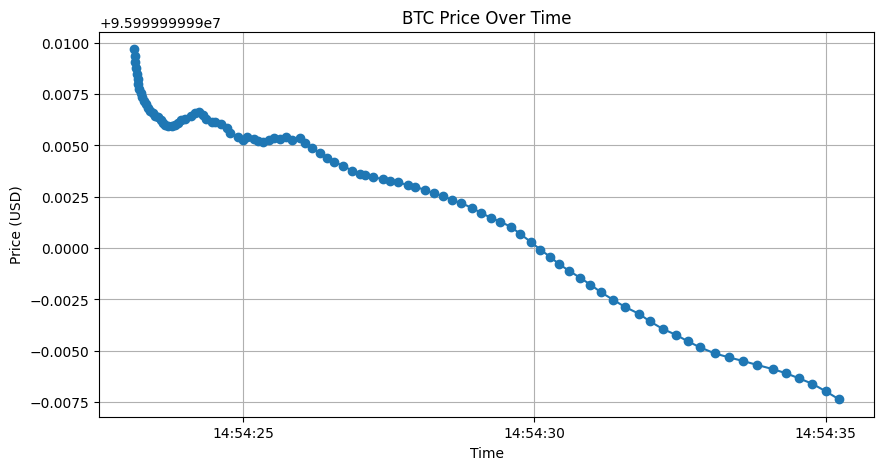

In [65]:
# Génération de 20 traders avec différents profils et d'un marché
market = Market()
trader_profiles = [MarketMaker, DegenTrader, SwingTrader, ArbitrageTrader]
traders = []
id = 0
market_price = market.price

nb_degens = 20
nb_market_makers = 0
nb_swing_traders = 0
nb_arbitrage_traders = 0

for _ in range(nb_degens) :
    trader = DegenTrader(id,random.randint(1000, 50000), market_price)
    traders.append(trader)
    id += 1
for _ in range(nb_market_makers) :
    trader = MarketMaker(id,random.randint(1000, 50000), market_price)
    traders.append(trader)
    id += 1
for _ in range(nb_swing_traders) :
    trader = SwingTrader(id,random.randint(1000, 50000), market_price)
    traders.append(trader)
    id += 1
for _ in range(nb_arbitrage_traders) :
    trader = ArbitrageTrader(id,random.randint(1000, 50000), market_price)
    traders.append(trader)
    id += 1

# Affichage des traders créés
for trader in traders:
    print(f"Trader {trader.trader_id}: {trader.__class__.__name__}, Balance: {trader.balance}, Leverage: {trader.leverage}, Herding Prob: {trader.herding_prob}")


# Initialize lists to store prices and timestamps
prices = []
timestamps = []


# Simulation over multiple time steps
for _ in range(100):  # For example, 100 time steps
    neighbor_positions = [trader.position for trader in traders]
    trend = "bearish"
    herd_position = max(set(neighbor_positions), key=neighbor_positions.count) if neighbor_positions else "BUY"
    # Generate random orders for each trader
    for trader in traders:
        if trader.position == "LIQUIDATED":
            traders = [t for t in traders if t.trader_id != trader.trader_id]
        else :
            order_type, quantity = trader.what_does_he_do(market.price, trend, herd_position)
            order_book.add_order(trader, order_type, quantity)

    df_order_book = order_book.get_order_book_df()
    new_price = market.update_price(order_book)
    prices.append(new_price)
    timestamps.append(datetime.now())

# Convert timestamps and prices to a DataFrame for plotting
df_prices = pd.DataFrame({'time': timestamps, 'price': prices})

# Plotting the prices over time
plt.figure(figsize=(10, 5))
plt.plot(df_prices['time'], df_prices['price'], marker='o')
plt.title('BTC Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.grid(True)
plt.show()
